In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [10]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Data Cleaning
customers.dropna(inplace=True)
transactions.dropna(inplace=True)

In [11]:
# Aggregate transaction data per customer
customer_transactions = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    last_transaction_date=("TransactionDate", "max")
).reset_index()

In [12]:
# Merge with customer profile data
customer_data = pd.merge(customers, customer_transactions, on="CustomerID", how="inner")


In [13]:
# Encode categorical features
le = LabelEncoder()
customer_data["Region"] = le.fit_transform(customer_data["Region"])

In [14]:
# Drop non-numeric columns not needed for clustering
customer_data.drop(["CustomerID", "CustomerName", "SignupDate", "last_transaction_date"], axis=1, inplace=True)

In [15]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

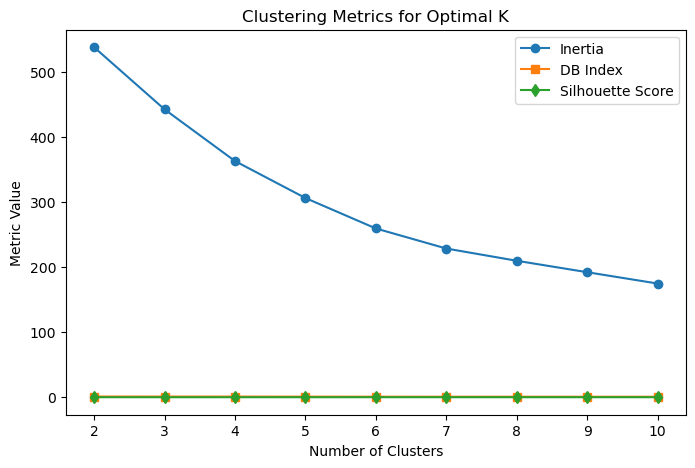

In [19]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
db_scores = []
sil_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))
    sil_scores.append(silhouette_score(scaled_data, kmeans.labels_))

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', label='Inertia')
plt.plot(k_values, db_scores, marker='s', label='DB Index')
plt.plot(k_values, sil_scores, marker='d', label='Silhouette Score')
plt.xlabel("Number of Clusters")
plt.ylabel("Metric Value")
plt.title("Clustering Metrics for Optimal K")
plt.legend()
plt.show()

In [20]:
# Apply K-Means Clustering
optimal_k = 4  # Choose based on the elbow method & metrics
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
customer_data["Cluster"] = kmeans.fit_predict(scaled_data)

In [21]:
# Calculate DB Index and Silhouette Score for selected model
db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
silhouette = silhouette_score(scaled_data, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Index: 1.202800531291985
Silhouette Score: 0.26016176087678383


In [25]:
# PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
customer_data["PCA1"] = reduced_data[:, 0]
customer_data["PCA2"] = reduced_data[:, 1]

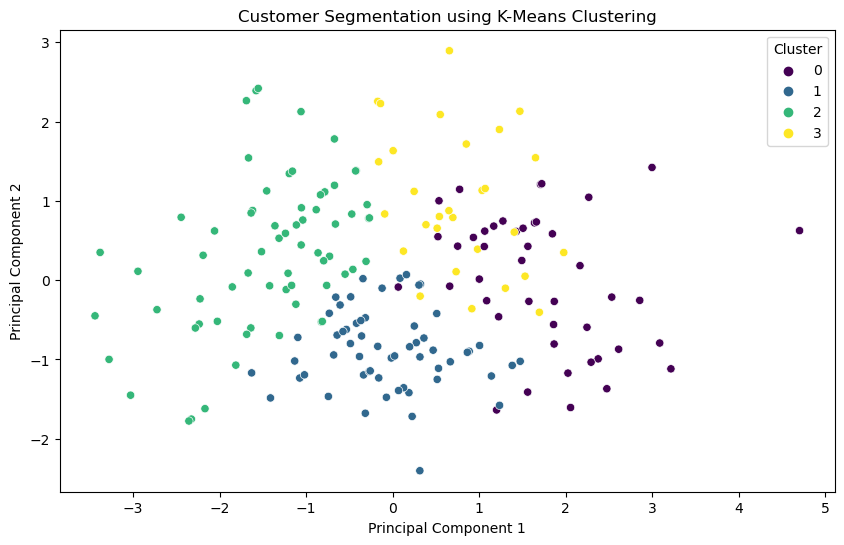

In [26]:
# Ensure PCA columns exist
if "PCA1" in customer_data.columns and "PCA2" in customer_data.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=customer_data["PCA1"], y=customer_data["PCA2"], hue=customer_data["Cluster"], palette="viridis")
    plt.title("Customer Segmentation using K-Means Clustering")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()
else:
    print("PCA columns not found in customer_data.")

In [27]:
# Save the segmented customers data
customer_data.to_csv("Customer_Segmentation.csv", index=False)